# Autoencoder-Based Anomaly Detection for CMS Open Payments

**Project:** AAI-540 Machine Learning Operations - Final Team Project  
**Context:** Continuation of notebook 03 - Feature Engineering & Model Preparation  
**Objective:** Train an Autoencoder model to detect anomalous payment patterns using reconstruction error as anomaly score

---

## Table of Contents
1. [Setup & Data Loading](#setup)
2. [Load Data from Stored Variables](#loading)
3. [Data Preparation & Normalization](#preparation)
4. [Autoencoder Architecture Design](#architecture)
5. [Model Training with Early Stopping](#training)
6. [Performance Evaluation](#evaluation)
7. [Anomaly Score Calculation & Validation](#scoring)
8. [Visualizations & Metrics](#visualizations)
9. [Summary & Outputs](#summary)

---

## 1. Setup & Data Loading

Load dependencies and restore configuration from notebook 03 (Feature Engineering).

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

2026-02-08 02:43:00.720473: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%store -r cms_payments_feature_group_name
%store -r record_identifier_feature_name
%store -r region
%store -r bucket
%store -r s3_athena_staging
%store -r database_name
%store -r table_name_parquet
%store -r offline_s3_uri
%store -r df

if 'df' not in dir() or df is None:
    raise NameError("Missing required variable 'df'. Run notebook 03 first.")

## 2. Load Data from Stored Variables

Use the engineered dataset from notebook 03.

In [3]:
df_payments = df.copy()
display(df_payments.head(3))

,total_amount_of_payment_usdollars,number_of_payments_included_in_total_amount,date_of_payment,covered_recipient_type,nature_of_payment_or_transfer_of_value,form_of_payment_or_transfer_of_value,recipient_state,covered_recipient_profile_id,covered_recipient_npi,applicable_manufacturer_or_applicable_gpo_making_payment_name,...,hist_pay_std,hist_pay_max,amt_to_avg_ratio,amt_to_max_ratio,is_new_recipient,is_high_risk_nature,total_amount_of_payment_usdollars_scaled,hist_pay_avg_scaled,hist_pay_std_scaled,amt_to_avg_ratio_scaled
0,21.68,1.0,2024-05-01,Covered Recipient Physician,Food and Beverage,In-kind items and services,NJ,189597.0,1.174589493E9,Bayer Healthcare Pharmaceuticals Inc.,...,0.000000,21.68,1.00000,1.000000,0,0,-0.006531,-0.007226,-0.006588,2.258894e-16
1,20.02,19.0,2024-05-01,Covered Recipient Non-Physician Practitioner,1,07/09/2024,MO,1.1436307E7,1.598470684E9,100000000226,...,2.588011,18.11,1.22973,1.105467,0,0,-0.006531,-0.007226,-0.006588,4.674152e-01
2,20.02,64.0,2024-05-01,Covered Recipient Physician,1,02/28/2024,OH,268013.0,1.912181389E9,100000186746,...,0.000000,20.02,1.00000,1.000000,0,0,-0.006531,-0.007226,-0.006588,2.258894e-16


## 3. Data Preparation & Normalization

Prepare features for Autoencoder training with appropriate scaling.

In [4]:
numeric_cols = df_payments.select_dtypes(include=[np.number]).columns.tolist()

cols_to_exclude = [
    'EventTime', 'covered_recipient_profile_id', 'index',
    'teaching_hospital_id', 'covered_recipient_npi',
    'covered_recipient_first_name', 'covered_recipient_middle_name',
    'covered_recipient_last_name', 'covered_recipient_name_suffix',
    'recipient_primary_business_street_address_line2',
    'recipient_zip_code', 'recipient_province', 'recipient_postal_code',
    'submitting_applicable_manufacturer_or_applicable_gpo_name',
    'applicable_manufacturer_or_applicable_gpo_making_payment_id',
    'applicable_manufacturer_or_applicable_gpo_making_payment_name'
]

numeric_features = [col for col in numeric_cols 
                   if col not in cols_to_exclude 
                   and not any(x in col.lower() for x in ['_id', '_name', '_address', '_code', '_province', '_postal'])]

X = df_payments[numeric_features].copy().astype(float)
X = X.replace([np.inf, -np.inf], np.nan)

missing_pct = (X.isnull().sum() / len(X)) * 100
cols_to_keep = missing_pct[missing_pct <= 50].index.tolist()
X = X[cols_to_keep]

for col in X.columns:
    q1, q3 = X[col].quantile(0.25), X[col].quantile(0.75)
    iqr = q3 - q1
    X[col] = X[col].clip(lower=q1 - 3*iqr, upper=q3 + 3*iqr)

X = X.fillna(X.median())

print(f"Data prepared: {X.shape} | Range: [{X.min().min():.2f}, {X.max().max():.2f}]")

Data prepared: (997362, 20) | Range: [-1.50, 2024.00]


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"Scaled: {X_scaled.shape} | Range: [{X_scaled.min().min():.4f}, {X_scaled.max().max():.4f}]")

X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")

Scaled: (997362, 20) | Range: [0.0000, 1.0000]
Train: 797,889 | Test: 199,473


## 4. Autoencoder Architecture Design

Design a deep Autoencoder with bottleneck layer for feature compression.

In [6]:
input_dim = X_scaled.shape[1]
encoding_dim_1 = max(input_dim // 2, 32)
encoding_dim_2 = max(input_dim // 4, 16)
bottleneck_dim = max(input_dim // 8, 8)

print(f"Architecture: {input_dim} -> {encoding_dim_1} -> {encoding_dim_2} -> {bottleneck_dim} (bottleneck)")

autoencoder = Sequential([
    layers.Dense(encoding_dim_1, activation='relu', input_shape=(input_dim,), name='encoder_input'),
    layers.Dropout(0.2),
    layers.Dense(encoding_dim_2, activation='relu', name='encoder_middle'),
    layers.Dropout(0.2),
    layers.Dense(bottleneck_dim, activation='relu', name='bottleneck'),
    layers.Dense(encoding_dim_2, activation='relu', name='decoder_middle'),
    layers.Dropout(0.2),
    layers.Dense(encoding_dim_1, activation='relu', name='decoder_layer'),
    layers.Dropout(0.2),
    layers.Dense(input_dim, activation='sigmoid', name='decoder_output')
], name='Autoencoder')

autoencoder.summary()

Architecture: 20 -> 32 -> 16 -> 8 (bottleneck)


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (Dense)           │ (None, 32)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_middle (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_middle (Dense)          │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_layer (Dense)           │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,684 (10.48 KB)

 Trainable params: 2,684 (10.48 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training with Early Stopping

Train the Autoencoder with optimal configuration and early stopping to prevent overfitting.

In [7]:
# Compile model with Adam optimizer
optimizer = Adam(learning_rate=0.001)
autoencoder.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

In [8]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1,
    min_delta=1e-5
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [9]:
start_time = time.time()

history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

training_time = time.time() - start_time
print(f"Training: {len(history.history['loss'])} epochs in {training_time:.2f}s")

Epoch 1/50
9974/9974 - 36s - 4ms/step - loss: 0.0224 - mae: 0.0914 - val_loss: 0.0106 - val_mae: 0.0560 - learning_rate: 0.0010
Epoch 2/50
9974/9974 - 41s - 4ms/step - loss: 0.0164 - mae: 0.0728 - val_loss: 0.0101 - val_mae: 0.0538 - learning_rate: 0.0010
Epoch 3/50
9974/9974 - 35s - 3ms/step - loss: 0.0150 - mae: 0.0678 - val_loss: 0.0094 - val_mae: 0.0505 - learning_rate: 0.0010
Epoch 4/50
9974/9974 - 31s - 3ms/step - loss: 0.0141 - mae: 0.0648 - val_loss: 0.0093 - val_mae: 0.0503 - learning_rate: 0.0010
Epoch 5/50
9974/9974 - 27s - 3ms/step - loss: 0.0137 - mae: 0.0634 - val_loss: 0.0094 - val_mae: 0.0497 - learning_rate: 0.0010
Epoch 6/50
9974/9974 - 27s - 3ms/step - loss: 0.0134 - mae: 0.0624 - val_loss: 0.0097 - val_mae: 0.0502 - learning_rate: 0.0010
Epoch 7/50
9974/9974 - 27s - 3ms/step - loss: 0.0132 - mae: 0.0619 - val_loss: 0.0091 - val_mae: 0.0500 - learning_rate: 0.0010
Epoch 8/50
9974/9974 - 27s - 3ms/step - loss: 0.0131 - mae: 0.0615 - val_loss: 0.0090 - val_mae: 0.0496 

## 6. Performance Evaluation

Evaluate model performance on training and test sets.

In [10]:
train_predictions = autoencoder.predict(X_train, verbose=0)
train_mse = np.mean(np.square(X_train - train_predictions), axis=1)

test_predictions = autoencoder.predict(X_test, verbose=0)
test_mse = np.mean(np.square(X_test - test_predictions), axis=1)

train_final_loss = history.history['loss'][-1]
val_final_loss = history.history['val_loss'][-1]

print(f"MSE - Train: {train_mse.mean():.6f} | Test: {test_mse.mean():.6f}")
print(f"Loss - Train: {train_final_loss:.6f} | Val: {val_final_loss:.6f}")

MSE - Train: 0.009038 | Test: 0.009029
Loss - Train: 0.012287 | Val: 0.009456


## 7. Anomaly Score Calculation & Validation

Generate anomaly scores, identify outliers using reconstruction error threshold, and validate results with payment details.

In [11]:
all_data = np.vstack([X_train, X_test])
all_predictions = autoencoder.predict(all_data, verbose=0)
all_reconstruction_errors = np.mean(np.square(all_data - all_predictions), axis=1)

threshold_percentile = 95
threshold = np.percentile(train_mse, threshold_percentile)

anomaly_labels = (all_reconstruction_errors > threshold).astype(int)
anomaly_count = anomaly_labels.sum()
anomaly_percentage = (anomaly_count / len(anomaly_labels)) * 100

print(f"Threshold (95th percentile): {threshold:.6f}")
print(f"Anomalies: {anomaly_count:,}/{len(anomaly_labels):,} ({anomaly_percentage:.2f}%)")
print(f"Score: Mean={all_reconstruction_errors.mean():.6f} | Median={np.median(all_reconstruction_errors):.6f} | Std={all_reconstruction_errors.std():.6f}")

Threshold (95th percentile): 0.022673
Anomalies: 49,746/997,362 (4.99%)
Score: Mean=0.009036 | Median=0.007338 | Std=0.007044


### Validation: Inspect Detected Anomalies

Examine the payment details of detected anomalies to validate model performance.

In [12]:
# Create results dataframe with anomaly scores
anomaly_results = df_payments.copy()
anomaly_results['reconstruction_error'] = all_reconstruction_errors
anomaly_results['is_anomaly'] = anomaly_labels
anomaly_results['anomaly_score_percentile'] = pd.Series(all_reconstruction_errors).rank(pct=True) * 100

# Filter anomalies and normal payments
anomalies_df = anomaly_results[anomaly_results['is_anomaly'] == 1].copy()
anomalies_df = anomalies_df.sort_values('reconstruction_error', ascending=False)
normal_df = anomaly_results[anomaly_results['is_anomaly'] == 0]

# Display key columns for top anomalies
display_cols = [
    'reconstruction_error', 
    'anomaly_score_percentile',
    'total_amount_of_payment_usdollars',
    'amt_to_avg_ratio',
    'hist_pay_avg',
    'is_new_recipient',
    'is_weekend',
    'is_high_risk_nature',
    'covered_recipient_type',
    'nature_of_payment_or_transfer_of_value'
]

available_cols = [col for col in display_cols if col in anomalies_df.columns]
print(f"Top 10 Anomalous Payments (n={len(anomalies_df):,}):")
display(anomalies_df[available_cols].head(10))

# Statistical comparison
comparison_features = ['total_amount_of_payment_usdollars', 'amt_to_avg_ratio', 'hist_pay_avg']
comparison_features = [f for f in comparison_features if f in anomaly_results.columns]

if comparison_features:
    comparison_stats = pd.DataFrame({
        'Normal_Mean': normal_df[comparison_features].mean(),
        'Normal_Median': normal_df[comparison_features].median(),
        'Anomaly_Mean': anomalies_df[comparison_features].mean(),
        'Anomaly_Median': anomalies_df[comparison_features].median(),
        'Difference_%': ((anomalies_df[comparison_features].mean() - normal_df[comparison_features].mean()) / 
                        normal_df[comparison_features].mean() * 100)
    })
    print("\nStatistical Comparison:")
    display(comparison_stats)

Top 10 Anomalous Payments (n=49,746):


,reconstruction_error,anomaly_score_percentile,total_amount_of_payment_usdollars,amt_to_avg_ratio,hist_pay_avg,is_new_recipient,is_weekend,is_high_risk_nature,covered_recipient_type,nature_of_payment_or_transfer_of_value
86880,0.088070,100.000000,0.73,1.000000,1.58361,0,0,0,Covered Recipient Non-Physician Practitioner,Food and Beverage
711746,0.083182,99.999900,20.02,1.000000,20.02000,0,0,0,Covered Recipient Physician,1
228535,0.082009,99.999799,25.21,1.259241,20.02000,0,0,0,Covered Recipient Physician,Food and Beverage
942939,0.081013,99.999699,20.02,1.061506,18.86000,0,0,0,Covered Recipient Physician,In-kind items and services
229321,0.079863,99.999599,124.99,6.243257,20.02000,0,0,0,Covered Recipient Non-Physician Practitioner,Food and Beverage
416671,0.078710,99.999499,18.99,0.948551,20.02000,0,0,0,Covered Recipient Non-Physician Practitioner,Food and Beverage
732940,0.078626,99.999398,20.02,1.000000,20.02000,0,0,0,Covered Recipient Physician,Cash or cash equivalent
435324,0.076026,99.999298,9.50,0.549133,17.30000,0,0,0,Covered Recipient Physician,Food and Beverage
738360,0.075814,99.999198,16.19,0.865544,18.70500,0,0,0,Covered Recipient Physician,Food and Beverage
833977,0.074781,99.999098,1611.00,4.795571,335.93500,0,0,0,Covered Recipient Physician,Consulting Fee



Statistical Comparison:


,Normal_Mean,Normal_Median,Anomaly_Mean,Anomaly_Median,Difference_%
total_amount_of_payment_usdollars,64.776034,20.02,62.243624,20.02,-3.909486
amt_to_avg_ratio,1.658161,1.00,1.639014,1.00,-1.154705
hist_pay_avg,58.802872,20.02,56.775892,20.02,-3.447076


In [14]:
# Anomaly distribution by key categories
categorical_cols = ['covered_recipient_type', 'nature_of_payment_or_transfer_of_value', 
                   'is_high_risk_nature', 'is_weekend', 'is_new_recipient']
categorical_cols = [col for col in categorical_cols if col in anomalies_df.columns]

if categorical_cols:
    print("\nAnomaly Distribution by Category:")
    for col in categorical_cols:
        print(f"\n{col}:")
        print(anomalies_df[col].value_counts().head(5))

# Reconstruction error statistics
error_stats = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Min', 'Max'],
    'Normal': [
        normal_df['reconstruction_error'].mean(),
        normal_df['reconstruction_error'].median(),
        normal_df['reconstruction_error'].min(),
        normal_df['reconstruction_error'].max()
    ],
    'Anomaly': [
        anomalies_df['reconstruction_error'].mean(),
        anomalies_df['reconstruction_error'].median(),
        anomalies_df['reconstruction_error'].min(),
        anomalies_df['reconstruction_error'].max()
    ]
})


print("\nReconstruction Error Statistics:")
display(error_stats)


Anomaly Distribution by Category:

covered_recipient_type:
covered_recipient_type
Covered Recipient Physician                     31848
Covered Recipient Non-Physician Practitioner    17898
Name: count, dtype: Int64

nature_of_payment_or_transfer_of_value:
nature_of_payment_or_transfer_of_value
Food and Beverage             25238
1                             17831
In-kind items and services     2307
Cash or cash equivalent        1005
Travel and Lodging              824
Name: count, dtype: Int64

is_high_risk_nature:
is_high_risk_nature
0    48869
1      877
Name: count, dtype: int64

is_weekend:
is_weekend
0    48004
1     1742
Name: count, dtype: int64

is_new_recipient:
is_new_recipient
0    39785
1     9961
Name: count, dtype: int64

Reconstruction Error Statistics:


,Metric,Normal,Anomaly
0,Mean,0.007939,0.029927
1,Median,0.007005,0.027550
2,Min,0.000094,0.022673
3,Max,0.022673,0.088070


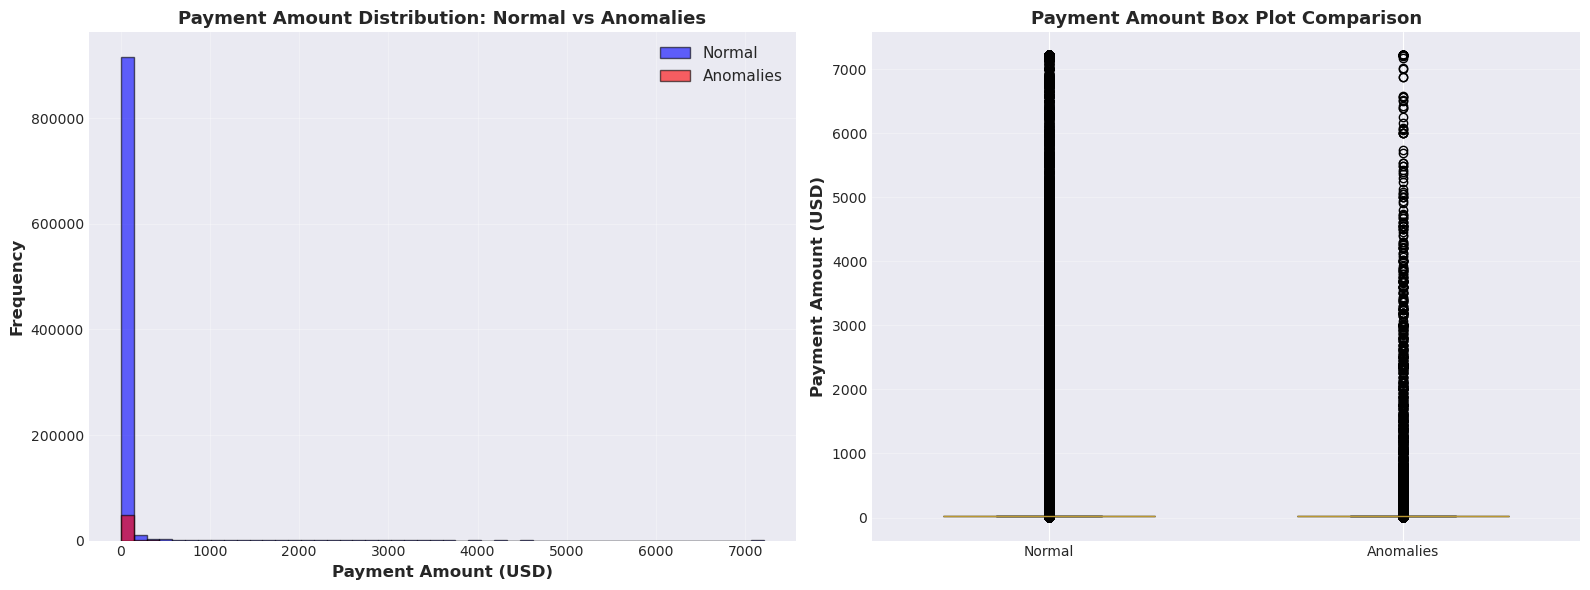

In [16]:
# Visualize payment amount distribution: Normal vs Anomalies
if 'total_amount_of_payment_usdollars' in anomaly_results.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    normal_amounts = normal_df['total_amount_of_payment_usdollars']
    anomaly_amounts = anomalies_df['total_amount_of_payment_usdollars']
    
    # Histogram comparison
    ax1 = axes[0]
    ax1.hist(normal_amounts, bins=50, alpha=0.6, label='Normal', color='blue', edgecolor='black')
    ax1.hist(anomaly_amounts, bins=50, alpha=0.6, label='Anomalies', color='red', edgecolor='black')
    ax1.set_xlabel('Payment Amount (USD)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax1.set_title('Payment Amount Distribution: Normal vs Anomalies', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Box plot comparison
    ax2 = axes[1]
    data_to_plot = [normal_amounts, anomaly_amounts]
    bp = ax2.boxplot(data_to_plot, labels=['Normal', 'Anomalies'], 
                     patch_artist=True, widths=0.6)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    ax2.set_ylabel('Payment Amount (USD)', fontsize=12, fontweight='bold')
    ax2.set_title('Payment Amount Box Plot Comparison', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')    
    plt.tight_layout()
    plt.show()

## 8. Visualizations & Metrics

Visualize training history, loss distributions, and anomaly scores.

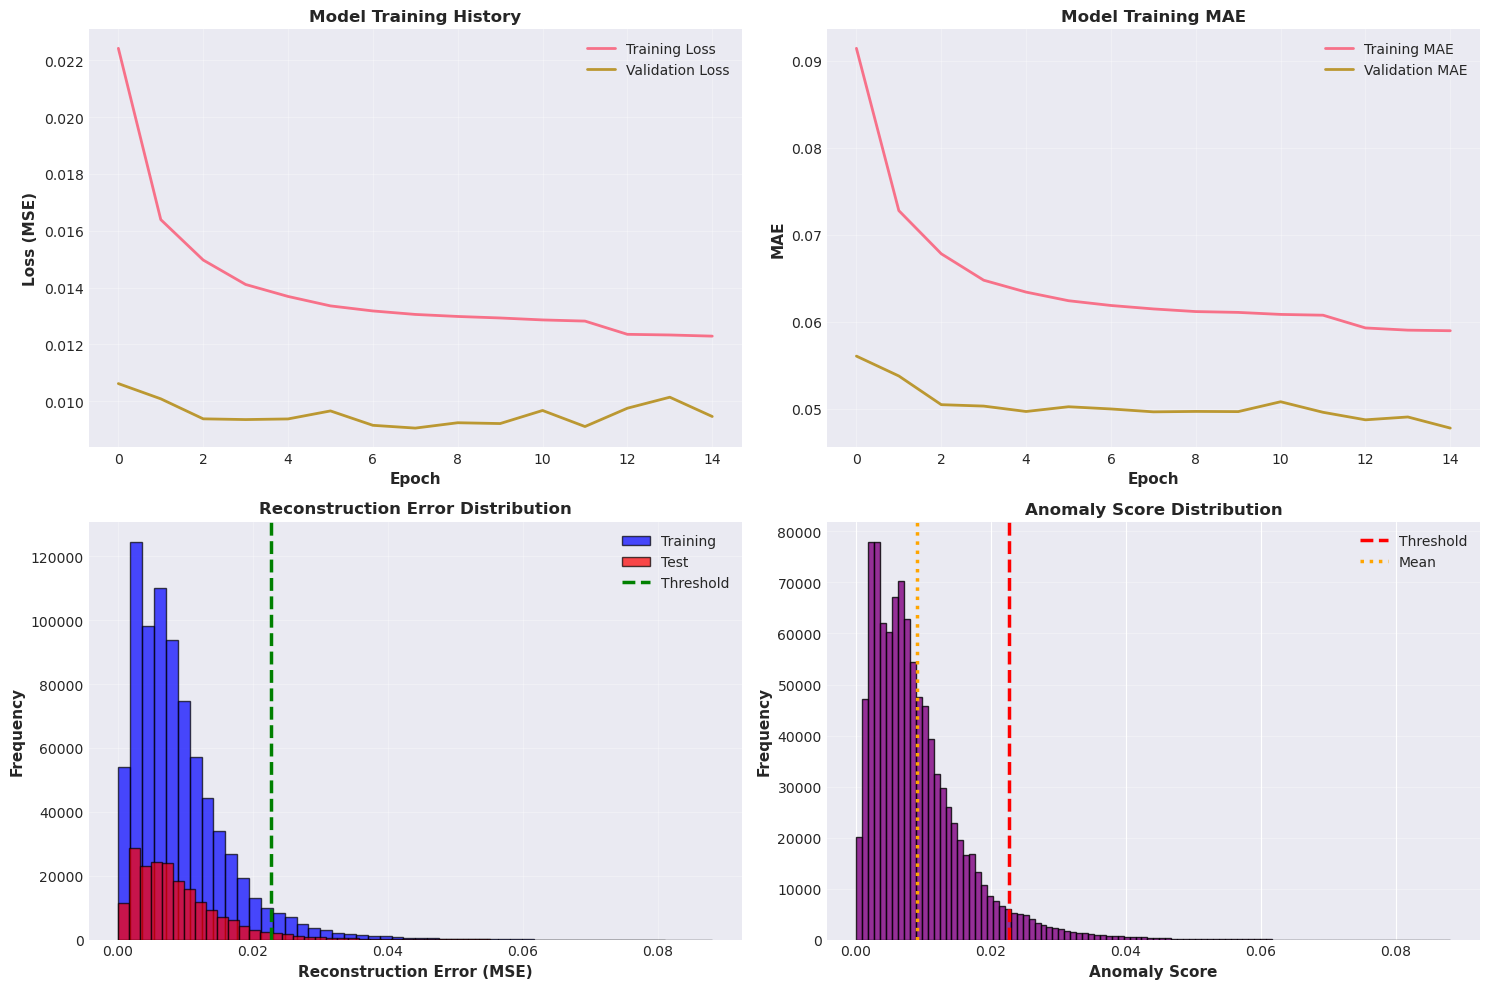

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ax1 = axes[0, 0]
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Loss (MSE)', fontsize=11, fontweight='bold')
ax1.set_title('Model Training History', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
ax2.plot(history.history['mae'], label='Training MAE', linewidth=2)
ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('MAE', fontsize=11, fontweight='bold')
ax2.set_title('Model Training MAE', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
ax3.hist(train_mse, bins=50, alpha=0.7, label='Training', color='blue', edgecolor='black')
ax3.hist(test_mse, bins=50, alpha=0.7, label='Test', color='red', edgecolor='black')
ax3.axvline(threshold, color='green', linestyle='--', linewidth=2.5, label=f'Threshold')
ax3.set_xlabel('Reconstruction Error (MSE)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax3.set_title('Reconstruction Error Distribution', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
ax4.hist(all_reconstruction_errors, bins=100, alpha=0.8, color='purple', edgecolor='black')
ax4.axvline(threshold, color='red', linestyle='--', linewidth=2.5, label='Threshold')
ax4.axvline(all_reconstruction_errors.mean(), color='orange', linestyle=':', linewidth=2.5, label='Mean')
ax4.set_xlabel('Anomaly Score', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title('Anomaly Score Distribution', fontsize=12, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

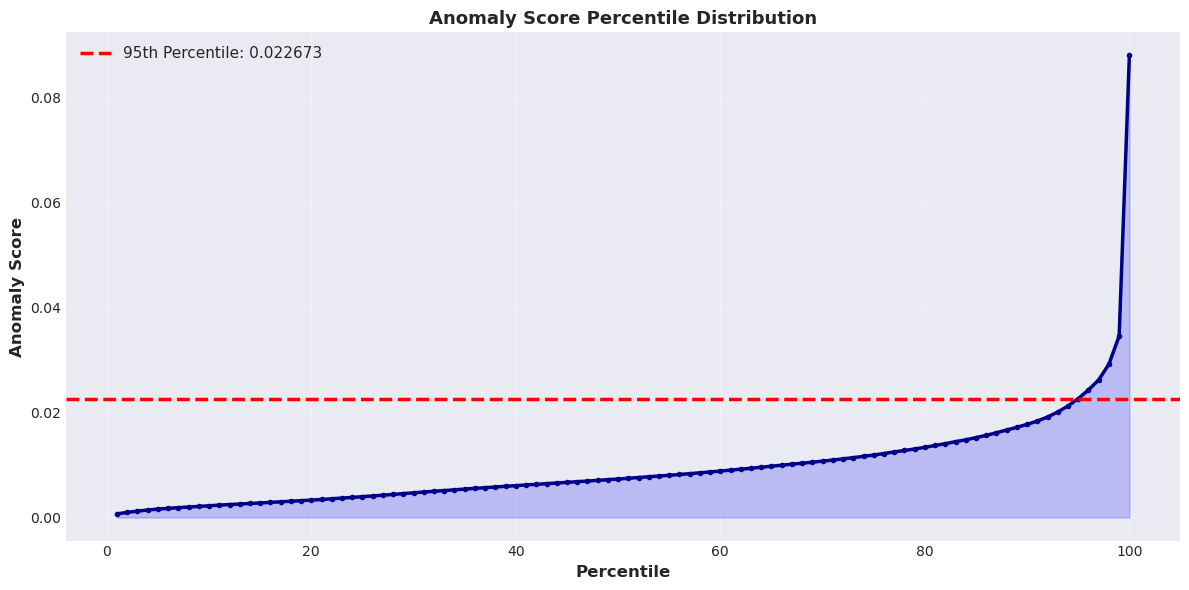

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

percentiles = np.arange(1, 101)
ax.plot(percentiles, np.percentile(all_reconstruction_errors, percentiles), 
        linewidth=2.5, color='darkblue', marker='o', markersize=3)
ax.axhline(y=threshold, color='red', linestyle='--', linewidth=2.5, 
           label=f'95th Percentile: {threshold:.6f}')
ax.fill_between(percentiles, 0, np.percentile(all_reconstruction_errors, percentiles), 
                alpha=0.2, color='blue')
ax.set_xlabel('Percentile', fontsize=12, fontweight='bold')
ax.set_ylabel('Anomaly Score', fontsize=12, fontweight='bold')
ax.set_title('Anomaly Score Percentile Distribution', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Summary & Outputs

Save model and anomaly detection results for downstream analysis.

In [19]:
model_path = 'cms_autoencoder_model.keras'
autoencoder.save(model_path)
print(f"Model saved: {model_path}")

scaler_path = 'feature_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved: {scaler_path}")

results_summary = pd.DataFrame({
    'Metric': ['Total Records', 'Anomalies Detected', 'Anomaly Percentage', 
               'Threshold', 'Mean Score', 'Training Time (sec)',
               'Epochs', 'Final Train Loss', 'Final Val Loss'],
    'Value': [len(anomaly_labels), anomaly_count, f'{anomaly_percentage:.2f}%',
              f'{threshold:.6f}', f'{all_reconstruction_errors.mean():.6f}',
              f'{training_time:.2f}', len(history.history['loss']),
              f'{train_final_loss:.6f}', f'{val_final_loss:.6f}']
})

print("\nExecution Summary:")
display(results_summary)

Model saved: cms_autoencoder_model.keras
Scaler saved: feature_scaler.pkl

Execution Summary:


,Metric,Value
0,Total Records,997362
1,Anomalies Detected,49746
2,Anomaly Percentage,4.99%
3,Threshold,0.022673
4,Mean Score,0.009036
5,Training Time (sec),451.72
6,Epochs,15
7,Final Train Loss,0.012287
8,Final Val Loss,0.009456
